In [1138]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

TEST_SIZE = 0.3
CV = 7
RSTATE = 12

PATH = r'D:\\DA\\Kaggle\Titanic\\'

# Exploratory Data Analysis

In [1139]:
data = pd.read_csv(PATH + 'train.csv')
data_pred = pd.read_csv(PATH + 'test.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1140]:
print(data.shape)
print(data_pred.shape)
X = data.drop(['Survived', 'PassengerId'], 1)
X_pred = data_pred.drop('PassengerId', 1)
y = data['Survived']
print(np.sum(y==0))
print(np.sum(y==1))

(891, 12)
(418, 11)
549
342


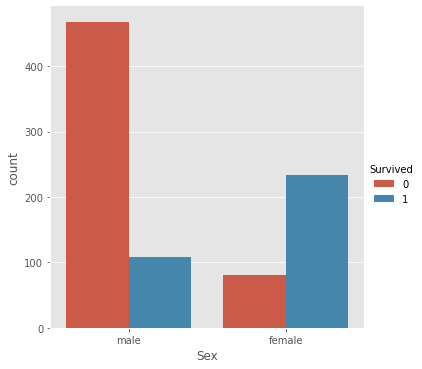

In [1141]:
sns.catplot(x='Sex', data=data, hue = 'Survived', kind = 'count');

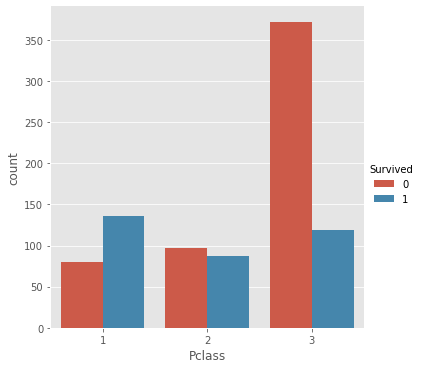

In [1142]:
sns.catplot(x='Pclass', data=data, hue = 'Survived', kind = 'count');

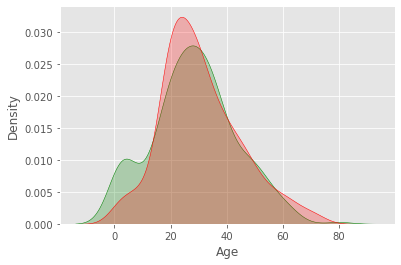

In [1143]:
sns.kdeplot(data['Age'][data['Survived'] == 1], color='green', shade=True);
sns.kdeplot(data['Age'][data['Survived'] == 0], color='red', shade=True);

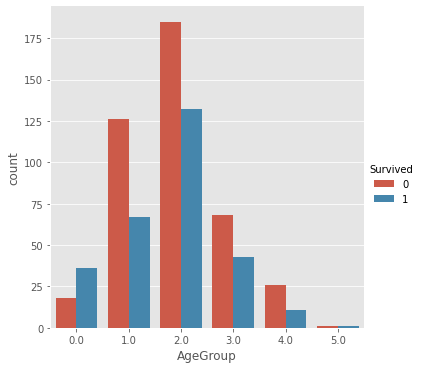

In [1144]:
data['AgeGroup'] = round(data['Age']/16)
sns.catplot(x='AgeGroup', data=data, hue = 'Survived', kind = 'count');

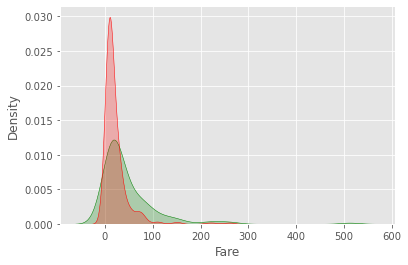

In [1145]:
sns.kdeplot(data['Fare'][data['Survived'] == 1], color='green', shade=True);
sns.kdeplot(data['Fare'][data['Survived'] == 0], color='red', shade=True);

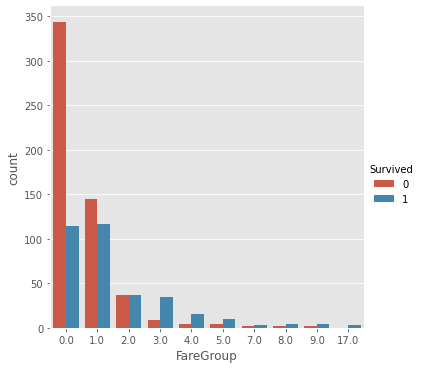

In [1146]:
data['FareGroup'] = round(data['Fare']/30)
sns.catplot(x='FareGroup', data=data, hue = 'Survived', kind = 'count');

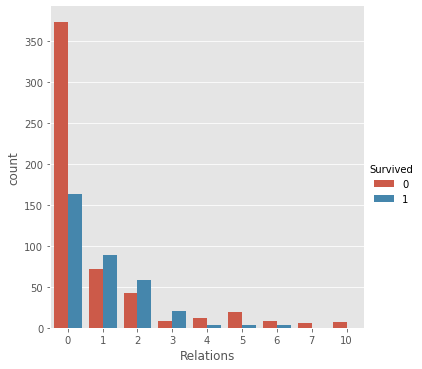

In [1147]:
data['Relations'] = data['SibSp'] + data['Parch']
sns.catplot(x='Relations', data=data, hue = 'Survived', kind = 'count');

In [1148]:
#Для обработки поля Cabin
def get_cab_num(cabin_str):
    try:
        if len(cabin_str) >= 4:
            cabin_str = cabin_str.split(' ')[-1]
        return int(cabin_str[1:])
    except:
        return 0
    
def get_cab_cat(cabin_num):
    if cabin_num == 0:
        return 0
    return cabin_num // 50 + 1

In [1149]:
#Для обработки поля Name
def sec_name(nm):
    return nm.split(',')[0]

def app_name(nm):
    sub = nm.split(',')[1]
    return sub.split('.')[0].strip()

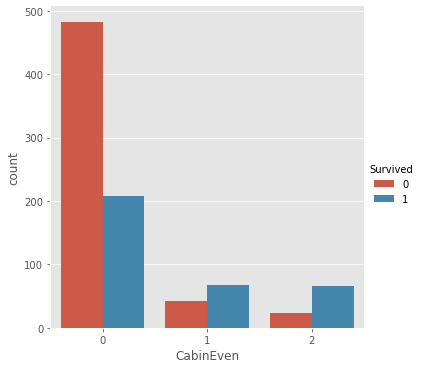

In [1150]:
data['CabinNumber'] = data['Cabin'].apply(get_cab_num)
data['CabinLetter'] = data['Cabin'].astype(str).apply(lambda x: x[0])
data['CabinEven'] = data['CabinNumber'].apply(lambda x: 0 if x==0 else x%2 + 1)
data['CabinCat'] = data['CabinNumber'].apply(get_cab_cat)
sns.catplot(x='CabinEven', data=data, hue = 'Survived', kind = 'count');

In [1151]:
data_pred['CabinLetter'] = data_pred['Cabin'].astype(str).apply(lambda x: x[0])
full_df = pd.concat([data, data_pred])

In [1152]:
full_df.groupby(['Pclass', 'CabinLetter'])['Fare'].describe()

count        mean         std      min      25%       50%  \
Pclass CabinLetter                                                              
1      A             22.0   41.244314   20.140358   0.0000  30.1250  35.07710   
       B             65.0  122.383078  115.312993   0.0000  57.0000  82.26670   
       C             94.0  107.926598   72.912034  25.7000  52.0000  86.28960   
       D             40.0   58.919065   25.256615  25.9292  33.5958  53.10000   
       E             34.0   63.464706   35.322753  25.5875  29.5375  55.44170   
       T              1.0   35.500000         NaN  35.5000  35.5000  35.50000   
       n             67.0   70.268157   80.114953   0.0000  26.5500  39.60000   
2      D              6.0   13.595833    0.829640  12.8750  13.0000  13.39585   
       E              4.0   11.587500    1.283469  10.5000  10.5000  11.42500   
       F             13.0   23.423077   12.306580  10.5000  13.0000  26.00000   
       n            254.0   21.394537   13.843615   0.0000  13.0000  15.66460   
3      E              3.0   11.000000    2.554775   8.0500  10.2625  12.47500   
       F              8.0    9.395838    5.241519   7.2292   7.5448   7.65000   
       G              5.0   14.205000    3.416419  10.4625  10.4625  16.70000   
       n            692.0   13.351522   11.602014   0.0000   7.7500   8.05000   

                           75%       max  
Pclass CabinLetter                        
1      A             50.371850   81.8583  
       B            146.520800  512.3292  
       C            151.550000  263.0000  
       D             76.868775  113.2750  
       E             79.650000  134.5000  
       T             35.500000   35.5000  
       n             79.200000  512.3292  
2      D             13.844800   15.0458  
       E             12.512500   13.0000  
       F             39.000000   39.0000  
       n             26.000000   73.5000  
3      E             12.475000   12.4750  
       F              7.675000   22.3583  
       G             16.700000   16.7000  
       n             15.245800   69.5500

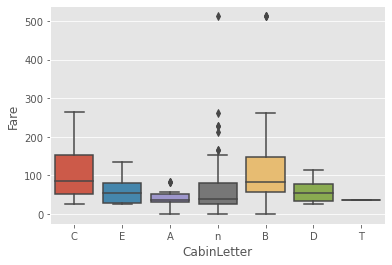

In [1153]:
sns.boxplot(x='CabinLetter', y='Fare', data=full_df[full_df['Pclass'] == 1]);

In [1154]:
# Generating CabinLetter when Cabin == NaN
def create_cletter(args):
    [cletter, ticket, fare, pclass]  = args
    if cletter != 'n':
        return cletter
    sub_df = full_df[(full_df['Ticket'] == ticket) & (full_df['CabinLetter'] != 'n')]
    if sub_df.shape[0] >= 1:   # There is another traveller with the same ticket and not blank Cabin
        return sub_df['CabinLetter'].values[0]
    if pclass == 1:
        return 'D' if fare < 75 else 'C'
    return cletter

In [1155]:
data['CabinLetter'] = data[['CabinLetter', 'Ticket', 'Fare', 'Pclass']].apply(create_cletter, axis=1)
data_pred['CabinLetter'] = data_pred[['CabinLetter', 'Ticket', 'Fare', 'Pclass']].apply(create_cletter, axis=1)

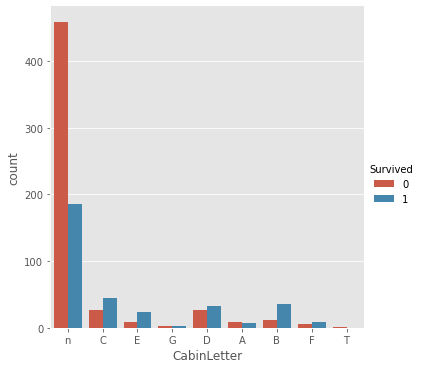

In [1156]:
sns.catplot(x='CabinLetter', data=data, hue = 'Survived', kind = 'count');

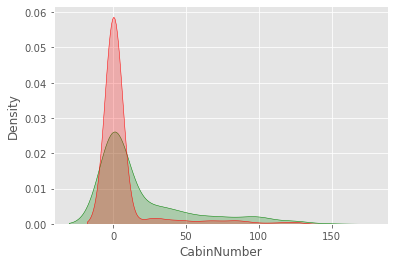

In [1157]:
sns.kdeplot(data['CabinNumber'][data['Survived'] == 1], color='green', shade=True);
sns.kdeplot(data['CabinNumber'][data['Survived'] == 0], color='red', shade=True);

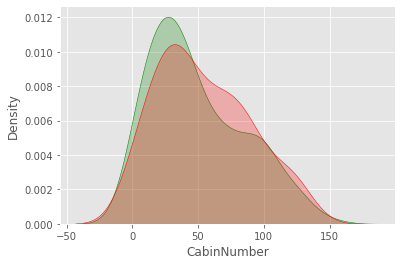

In [1158]:
sns.kdeplot(data[data['CabinNumber']!=0]['CabinNumber'][data['Survived'] == 1], color='green', shade=True);
sns.kdeplot(data[data['CabinNumber']!=0]['CabinNumber'][data['Survived'] == 0], color='red', shade=True);

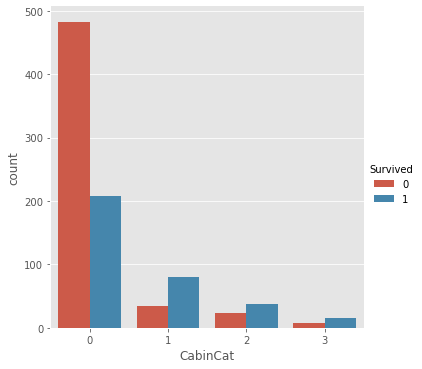

In [1159]:
sns.catplot(x='CabinCat', data=data, hue = 'Survived', kind = 'count');

In [1160]:
# Leaderboard Probing
y_probing = np.array([1]*data_pred.shape[0])
probing = pd.DataFrame({'PassengerId': data_pred.PassengerId, 'Survived': y_probing})
probing.to_csv(PATH + 'titanic_probing.csv', index=False)
# Accuracy = 0.37799

In [1161]:
print("Number of Passengers in Train Set: {}".format(data.shape[0]))
print("Number of Survived in Train Set: {} ({:.1%})".format(sum(y==1), sum(y==1)/y.shape[0]))
perc = 0.37799
n_surv = round(data_pred.shape[0] * perc)
print("Number of Passengers in Test Set: {}".format(data_pred.shape[0]))
print("Number of Survived in Test Set: {} ({:.1%})".format(n_surv, perc))

Number of Passengers in Train Set: 891
Number of Survived in Train Set: 342 (38.4%)
Number of Passengers in Test Set: 418
Number of Survived in Test Set: 158 (37.8%)


In [1162]:
def tune_pred(y_proba):
    thr = sorted(y_proba, reverse=True)[n_surv]
    return np.array([int(p>thr) for p in y_proba])    

In [1163]:
def submit(y_pred, filename):
    output = pd.DataFrame({'PassengerId': data_pred.PassengerId, 'Survived': y_pred})
    output.to_csv(PATH + filename, index=False)
    print("Your submission was successfully saved: " + filename)

In [1164]:
# Features generating for all models
X['Relatives'] = X['SibSp'] + X['Parch']
X_pred['Relatives'] = X_pred['SibSp'] + X_pred['Parch']

X['SecondName'] = X['Name'].apply(sec_name)
X_pred['SecondName'] = X_pred['Name'].apply(sec_name)

X['AppName'] = X['Name'].apply(app_name)
X_pred['AppName'] = X_pred['Name'].apply(app_name)

X['CabinNumber'] = X['Cabin'].apply(get_cab_num)
X['CabinLetter'] = X['Cabin'].astype(str).apply(lambda x: x[0])
X['CabinEven'] = X['CabinNumber'].apply(lambda x: 0 if x==0 else x%2 + 1)

X_pred['CabinNumber'] = X_pred['Cabin'].apply(get_cab_num)
X_pred['CabinLetter'] = X_pred['Cabin'].astype(str).apply(lambda x: x[0])
X_pred['CabinEven'] = X_pred['CabinNumber'].apply(lambda x: 0 if x==0 else x%2 + 1)

X['CabinLetter'] = X[['CabinLetter', 'Ticket', 'Fare', 'Pclass']].apply(create_cletter, axis=1)
X_pred['CabinLetter'] = X_pred[['CabinLetter', 'Ticket', 'Fare', 'Pclass']].apply(create_cletter, axis=1)

In [1165]:
# Saving the data for all models
X.to_csv(PATH + 'x_train.csv', index=False)
X_pred.to_csv(PATH + 'x_pred.csv', index=False)
y.to_csv(PATH + 'y.csv', index=False)

In [1166]:
def get_data():
    X_train = pd.read_csv(PATH + 'x_train.csv')
    X_test = pd.read_csv(PATH + 'x_pred.csv')
    y = pd.read_csv(PATH + 'y.csv')
    return X_train, X_test, y

# Model 1: Logistic Regression

## Feature Preprocessing for Logistic Regression

In [1167]:
X_lr, X_pred_lr, y = get_data()

In [1168]:
X_lr['Male'] = (X_lr['Sex'] == 'male').astype(int)
X_pred_lr['Male'] = (X_pred_lr['Sex'] == 'male').astype(int)

X_lr['Rel_in_13'] = X_lr['Relatives'].apply(lambda x: x>=1 and x<=3).astype(int)
X_pred_lr['Rel_in_13'] = X_pred_lr['Relatives'].apply(lambda x: x>=1 and x<=3).astype(int)

X_lr['CabinCat'] = X_lr['CabinNumber'].apply(get_cab_cat)
X_pred_lr['CabinCat'] = X_pred_lr['CabinNumber'].apply(get_cab_cat)

age_dict = pd.DataFrame(pd.concat([X_lr, X_pred_lr]).groupby('AppName')['Age'].median()).squeeze().to_dict()
X_lr['Age'] = X_lr['Age'].fillna(X_lr['AppName'].map(age_dict))
X_pred_lr['Age'] = X_pred_lr['Age'].fillna(X_pred_lr['AppName'].map(age_dict))

X_lr['AgeGroup'] = round(X_lr['Age']/16).astype(int)
X_pred_lr['AgeGroup'] = round(X_pred_lr['Age']/16).astype(int)

X_lr.drop(['Name', 'Sex', 'Parch', 'Cabin'], axis=1, inplace = True)
X_pred_lr.drop(['Name', 'Sex', 'Parch', 'Cabin'], axis=1, inplace = True)

In [1169]:
numeric_cols = ['Age', 'Pclass', 'SibSp', 'Fare', 'Male', 'CabinNumber', 'Relatives', 'Rel_in_13'] #   , 
categorical_cols = list(set(X_lr.columns.values.tolist()) - set(numeric_cols))

In [1170]:
X_lr.isnull().sum(), X_pred_lr.isnull().sum()

(Pclass         0
 Age            0
 SibSp          0
 Ticket         0
 Fare           0
 Embarked       2
 Relatives      0
 SecondName     0
 AppName        0
 CabinNumber    0
 CabinLetter    0
 CabinEven      0
 Male           0
 Rel_in_13      0
 CabinCat       0
 AgeGroup       0
 dtype: int64,
 Pclass         0
 Age            0
 SibSp          0
 Ticket         0
 Fare           1
 Embarked       0
 Relatives      0
 SecondName     0
 AppName        0
 CabinNumber    0
 CabinLetter    0
 CabinEven      0
 Male           0
 Rel_in_13      0
 CabinCat       0
 AgeGroup       0
 dtype: int64)

In [1171]:
# Filling missing values
X_real = pd.DataFrame()  # X_real_mean
X_pred_real = pd.DataFrame()

for num_col in [numeric_cols]:   
    X_real[num_col] = X_lr[num_col].fillna(X_lr[num_col].median())
    X_pred_real[num_col] = X_pred_lr[num_col].fillna(X_pred_lr[num_col].median())
    
X_cat = pd.DataFrame()
X_pred_cat = pd.DataFrame()
for cat_col in categorical_cols:
    X_cat[cat_col] = X_lr[cat_col].fillna('NA', inplace=False).astype(str)  
    X_pred_cat[cat_col] = X_pred_lr[cat_col].fillna('NA', inplace=False).astype(str)      

In [1172]:
from scipy.spatial import distance
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Returns mean target value of count closest objects for each object in (X_train_sc, X_test_sc)
# Version 2
def get_mean_target(X_train, X_test, num_cols, target, count):
    train_size, test_size = X_train.shape[0], X_test.shape[0]
    X_train_df = pd.DataFrame()
    X_test_df = pd.DataFrame()
    cat_cols = list(set(X_test.columns.values.tolist()) - set(num_cols))
    X_all_cat_df = pd.concat([X_train[cat_cols], X_test[cat_cols]])
    
    for col in num_cols:  
        X_train_df[col] = X_train[col].fillna(X_train[col].median())
        X_test_df[col] = X_test[col].fillna(X_test[col].median())
    
    scaler = StandardScaler()
    X_num_all = pd.concat((X_train_df, X_test_df), axis=0)
    scaler.fit(X_num_all)
    X_train_arr = scaler.transform(X_train_df)
    X_test_arr = scaler.transform(X_test_df)

    for col in cat_cols:
        X_all_cat_df[col] = X_all_cat_df[col].fillna('NA').astype(str)

    encoder = OneHotEncoder(sparse=False)
    X_all_cat = encoder.fit_transform(X_all_cat_df)  
    X_train_cat = X_all_cat[:train_size]
    X_test_cat = X_all_cat[train_size:]

    X_train_sc = np.hstack((X_train_arr, X_train_cat))
    X_test_sc = np.hstack((X_test_arr, X_test_cat))
    
    median_list = np.zeros(train_size + test_size)
    for i in tqdm(range(train_size + test_size)):
        obj = X_train_sc[i] if i < train_size else X_test_sc[i - train_size]
        dst = []  #list: [object_index, distance_to_object]
        for j in range(train_size):
            if i!=j:
                dst.append([j, distance.euclidean(obj, X_train_sc[j])])
        dst.sort(key=lambda x: x[1])
        idx = [x[0] for x in dst[:count]]  # Indexes of the closest objects
        target_list = [target.values[x] for x in idx]
        median_list[i] = np.mean(target_list)
    return median_list[:train_size], median_list[train_size:]

In [1173]:
a, b = get_mean_target(pd.concat((X_real, X_cat), axis=1), \
                       pd.concat((X_pred_real, X_pred_cat), axis=1), \
                       numeric_cols, y, 10)

100%|██████████████████████████████████████| 1309/1309 [00:15<00:00, 85.14it/s]


In [1174]:
# Adding new feature: Mean target value of 10 closest objects
X_real['MeanTarget'] = a
X_pred_real['MeanTarget'] = b
numeric_cols += ['MeanTarget']
numeric_cols

['Age',
 'Pclass',
 'SibSp',
 'Fare',
 'Male',
 'CabinNumber',
 'Relatives',
 'Rel_in_13',
 'MeanTarget']

In [1175]:
# Uniting categorical features for full dictionary
X_cat_full = np.vstack((X_cat, X_pred_cat))
X_size = X_cat.shape[0]
X_pred_size = X_pred_cat.shape[0]
print(X_cat.shape, X_pred_cat.shape, X_cat_full.shape, X_size, X_pred_size)

X_cat_full_df = pd.DataFrame(X_cat_full)

from sklearn.feature_extraction import DictVectorizer as DV
encoder = DV(sparse=False)
X_cat_full = encoder.fit_transform(X_cat_full_df.T.to_dict().values())

X_cat_oh = X_cat_full[:X_size]
X_pred_cat_oh = X_cat_full[-X_pred_size:]
print(X_cat_oh.shape, X_pred_cat_oh.shape)

(891, 8) (418, 8) (1309, 8) 891 418
(891, 1848) (418, 1848)


In [1176]:
# Numerical features scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_real_all = np.vstack((X_real, X_pred_real))
scaler.fit(X_real_all)
X_real = scaler.transform(X_real)
X_pred_real = scaler.transform(X_pred_real)
#X_real.shape

In [1177]:
(X_train_real, X_test_real, y_train, y_test) = train_test_split(X_real, y, test_size=TEST_SIZE, random_state=RSTATE)
(X_train_cat_oh, X_test_cat_oh) = train_test_split(X_cat_oh, test_size=TEST_SIZE, random_state=RSTATE)
X_train_cat = np.hstack((X_train_real, X_train_cat_oh))
X_test_cat = np.hstack((X_test_real, X_test_cat_oh))
X_pred_cat = np.hstack((X_pred_real, X_pred_cat_oh))
X_all = np.hstack((X_real, X_cat_oh))
X_all.shape

(891, 1857)

# Model Training and Fitting

In [1178]:
from sklearn.linear_model import LogisticRegression

In [1179]:
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RSTATE)
param_grid = {'C': np.concatenate((np.arange(0.25, 5, 0.25), np.arange(5, 25)))}
estimator = LogisticRegression()

In [1180]:
X_train_cat.shape

(623, 1857)

In [1181]:
optimizer_lr = GridSearchCV(estimator, param_grid = param_grid, cv=CV, n_jobs=-1, verbose=True)
optimizer_lr.fit(X_train_cat, y_train)

Fitting 7 folds for each of 39 candidates, totalling 273 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 273 out of 273 | elapsed:   21.4s finished


GridSearchCV(cv=7, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([ 0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,
        2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,
        4.75,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  ,
       22.  , 23.  , 24.  ])},
             verbose=True)

In [1182]:
print(optimizer_lr.best_params_)
print(optimizer_lr.best_score_)
model_rf = optimizer_lr.best_estimator_

{'C': 0.5}
0.8410914927768861


In [1183]:
# Feature Importance - Numerical
dict(zip(numeric_cols, optimizer_lr.best_estimator_.coef_.T[:X_train_real.shape[1]]))

{'Age': array([-0.14184695]),
 'Pclass': array([-0.49915076]),
 'SibSp': array([-0.18587267]),
 'Fare': array([0.02111362]),
 'Male': array([-0.52626763]),
 'CabinNumber': array([-0.08594104]),
 'Relatives': array([-0.09444701]),
 'Rel_in_13': array([-0.0111008]),
 'MeanTarget': array([1.05285584])}

In [1184]:
# Feature Importance - Categorical
#dict(zip(encoder.feature_names_, optimizer_lr.best_estimator_.coef_.T[X_train_real.shape[1]:]))

In [1185]:
# Predict for valid part
X_test_cat = np.hstack((X_test_real, X_test_cat_oh))
y_proba_test_pred_lr = model_rf.predict_proba(X_test_cat)
y_test_pred_lr = model_rf.predict(X_test_cat)

acc_lr = accuracy_score(y_test, y_test_pred_lr) 
auc_lr = roc_auc_score(y_test, y_proba_test_pred_lr[:,1]) 

print("Accuracy Test LR = ", acc_lr)
print("AUC Test LR = ", auc_lr)

Accuracy Test LR =  0.8246268656716418
AUC Test LR =  0.8616125848958031


In [1186]:
# Model training on all data
logr = optimizer_lr.best_estimator_
logr.fit(X_all, y)
y_pred_lr = logr.predict(X_pred_cat)

In [1187]:
submit(y_pred_lr, 'my_submission_lr.csv')
print("Number of Survivers according to the model: {}".format(sum(y_pred_lr)))
print("Real number of Survivers: {}".format(n_surv))
submit(tune_pred(logr.predict_proba(X_pred_cat)[:, 1]), 'my_submission_lr_tuned.csv')

Your submission was successfully saved: my_submission_lr.csv
Number of Survivers according to the model: 162
Real number of Survivers: 158
Your submission was successfully saved: my_submission_lr_tuned.csv


# Model 2: RandomForestClassifier

## Feature Preprocessing for RandomForest

In [1188]:
X_rf, X_pred_rf, y = get_data()

In [1189]:
X_size = X_rf.shape[0]
X_rf.drop(['Name'], axis=1, inplace=True)
X_pred_rf.drop(['Name'], axis=1, inplace=True)

In [1190]:
X_ftmp = pd.concat((X_rf, X_pred_rf))
uniq_tickets = list(X_ftmp['Ticket'].value_counts()[X_ftmp['Ticket'].value_counts()==1].index)
uniq_secname = list(X_ftmp['SecondName'].value_counts()[X_ftmp['SecondName'].value_counts()==1].index)

In [1191]:
age_dict = pd.DataFrame(pd.concat([X_rf, X_pred_rf]).groupby('AppName')['Age'].median()).squeeze().to_dict()
ticket_dict = pd.DataFrame(pd.concat([X_rf, X_pred_rf]).groupby('Ticket')['Ticket'].count()).squeeze().to_dict()

X_rf['Age'] = X_rf['Age'].fillna(X_rf['AppName'].map(age_dict))
X_pred_rf['Age'] = X_pred_rf['Age'].fillna(X_pred_rf['AppName'].map(age_dict))

X_rf['NTickets'] = X_rf['Ticket'].map(ticket_dict)
X_pred_rf['NTickets'] = X_pred_rf['Ticket'].map(ticket_dict)

X_rf['UniqTicket'] = X_rf['Ticket'].isin(uniq_tickets).astype(int)
X_pred_rf['UniqTicket'] = X_pred_rf['Ticket'].isin(uniq_tickets).astype(int)
X_rf['UniqSecName'] = X_rf['SecondName'].isin(uniq_secname).astype(int)
X_pred_rf['UniqSecName'] = X_pred_rf['SecondName'].isin(uniq_secname).astype(int)
X_rf['Ticket'] = X_rf['Ticket'] * (1 - X_rf['UniqTicket'])
X_pred_rf['Ticket'] = X_pred_rf['Ticket'] * (1 - X_pred_rf['UniqTicket'])
X_rf['SecondName'] = X_rf['SecondName'] * (1 - X_rf['UniqSecName'])
X_pred_rf['SecondName'] = X_pred_rf['SecondName'] * (1 - X_pred_rf['UniqSecName'])
X_rf.drop(['UniqSecName', 'UniqTicket'], axis=1, inplace = True)
X_pred_rf.drop(['UniqSecName', 'UniqTicket'], axis=1, inplace = True)

X_rf['ClassCabNum'] = X_rf['Pclass'].astype(str) + '-' + X_rf['CabinNumber'].astype(str)
X_pred_rf['ClassCabNum'] = X_pred_rf['Pclass'].astype(str) + '-' + X_pred_rf['CabinNumber'].astype(str)

X_rf['SexRel'] = X_rf['Sex'].astype(str) + '-' + X_rf['Relatives'].astype(str)
X_pred_rf['SexRel'] = X_pred_rf['Sex'].astype(str) + '-' + X_pred_rf['Relatives'].astype(str)

X_rf['ClassSex'] = X_rf['Pclass'].astype(str) + '-' + X_rf['Sex'].astype(str)
X_pred_rf['ClassSex'] = X_pred_rf['Pclass'].astype(str) + '-' + X_pred_rf['Sex'].astype(str)

In [1192]:
rf_num_cols = list(X_rf.dtypes[X_rf.dtypes!='object'].index)
rf_cat_cols = list(set(X_rf.columns) - set(rf_num_cols))
print("Numeric columns: ", rf_num_cols)
print("Categorical columns: ", rf_cat_cols)

Numeric columns:  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Relatives', 'CabinNumber', 'CabinEven', 'NTickets']
Categorical columns:  ['Ticket', 'Cabin', 'CabinLetter', 'SecondName', 'Sex', 'ClassSex', 'SexRel', 'AppName', 'Embarked', 'ClassCabNum']


In [1193]:
X_cat_full_rf = pd.concat([X_rf[rf_cat_cols], X_pred_rf[rf_cat_cols]])
X_num_full_rf = pd.concat([X_rf[rf_num_cols], X_pred_rf[rf_num_cols]])

In [1194]:
X_cat_full_rf = X_cat_full_rf.fillna('NA').astype(str)
X_cat_full_rf.isna().sum()

Ticket         0
Cabin          0
CabinLetter    0
SecondName     0
Sex            0
ClassSex       0
SexRel         0
AppName        0
Embarked       0
ClassCabNum    0
dtype: int64

In [1195]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in X_cat_full_rf.columns:
    X_cat_full_rf[col] = le.fit_transform(X_cat_full_rf[col])

In [1196]:
X_num_full_rf = X_num_full_rf.fillna(-1)
X_num_full_rf.isna().sum()

Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Relatives      0
CabinNumber    0
CabinEven      0
NTickets       0
dtype: int64

In [1197]:
X_rf = np.hstack((X_num_full_rf[:X_size], X_cat_full_rf[:X_size]))
X_pred_rf = np.hstack((X_num_full_rf[X_size:], X_cat_full_rf[X_size:]))
X_rf.shape, X_pred_rf.shape

((891, 19), (418, 19))

In [1198]:
(X_train_rf, X_test_rf, y_train_rf, y_test_rf) = train_test_split(X_rf, y, test_size=TEST_SIZE, random_state=RSTATE)

## Model Training and Fitting

In [1199]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [1200]:
param_grid = {'max_depth' : np.concatenate((np.arange(5, 12), np.arange(12, 25, 2), np.arange(25, 150, 5))),
              'max_features' : range(4, X_rf.shape[1]-3),
              'min_samples_leaf' : np.concatenate((np.arange(1, 12), np.arange(12, 25, 2))),
               'criterion' : ["gini", "entropy"]
             }

In [1201]:
rand_grid = RandomizedSearchCV(RandomForestClassifier(random_state=RSTATE, n_estimators=150), \
                               param_distributions=param_grid, cv=CV, verbose=True, n_jobs=-1, n_iter=250)
rand_grid.fit(X_train_rf, y_train_rf)

Fitting 7 folds for each of 250 candidates, totalling 1750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:   55.3s finished


RandomizedSearchCV(cv=7,
                   estimator=RandomForestClassifier(n_estimators=150,
                                                    random_state=12),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([  5,   6,   7,   8,   9,  10,  11,  12,  14,  16,  18,  20,  22,
        24,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145]),
                                        'max_features': range(4, 16),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16, 18, 20, 22,
       24])},
                   verbose=True)

In [1202]:
print(rand_grid.best_params_)
print(rand_grid.best_score_)

{'min_samples_leaf': 2, 'max_features': 6, 'max_depth': 90, 'criterion': 'entropy'}
0.8571428571428571


In [1203]:
all_cols = list(rf_num_cols + rf_cat_cols)
feat_imp = dict(zip(all_cols, rand_grid.best_estimator_.feature_importances_))
{k: v for k, v in sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)}

{'SexRel': 0.17370199152284282,
 'Age': 0.11937096549774942,
 'Fare': 0.11564790854306331,
 'Sex': 0.09877393697639515,
 'ClassSex': 0.08341288380771904,
 'SecondName': 0.057590132104460894,
 'ClassCabNum': 0.05027717832087694,
 'AppName': 0.05018926830501461,
 'Ticket': 0.03516337417675718,
 'NTickets': 0.03496360489252054,
 'Pclass': 0.03244781866418719,
 'CabinNumber': 0.029338231745492934,
 'Embarked': 0.025378656310242536,
 'Relatives': 0.023642388624654745,
 'Cabin': 0.022559421768580917,
 'CabinLetter': 0.01842911739739787,
 'SibSp': 0.013877372102380608,
 'CabinEven': 0.008599464282341237,
 'Parch': 0.006636284957322034}

In [1204]:
# Predict for valid_data
y_proba_test_pred_rf = rand_grid.predict_proba(X_test_rf)
y_test_pred_rf = rand_grid.predict(X_test_rf)

acc_rf = accuracy_score(y_test_rf, y_test_pred_rf) 
auc_rf = roc_auc_score(y_test_rf, y_proba_test_pred_rf[:,1])

print("Accuracy Test RF = ", acc_rf)
print("AUC Test RF = ", auc_rf)

Accuracy Test RF =  0.7985074626865671
AUC Test RF =  0.8427468508736286


In [1205]:
# Model Training on all data
rf = rand_grid.best_estimator_
rf.fit(X_rf, y)
y_pred_rf = rf.predict(X_pred_rf)

In [1206]:
submit(y_pred_rf, 'my_submission_rf.csv')
print("Number of Survivers according to the model: {}".format(sum(y_pred_rf)))
print("Real number of Survivers: {}".format(n_surv))
submit(tune_pred(rf.predict_proba(X_pred_rf)[:, 1]), 'my_submission_rf_tuned.csv')

Your submission was successfully saved: my_submission_rf.csv
Number of Survivers according to the model: 160
Real number of Survivers: 158
Your submission was successfully saved: my_submission_rf_tuned.csv


# Model 3: LightGBM

In [1207]:
from lightgbm import LGBMClassifier

In [1208]:
#X_gbm, X_pred_gbm, y = get_data()
X_gbm = X_rf.copy()
X_pred_gbm = X_pred_rf.copy()
print(X_gbm.shape, X_pred_gbm.shape)
(X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm) = train_test_split(X_gbm, y, test_size=TEST_SIZE, random_state=RSTATE)

(891, 19) (418, 19)


In [1209]:
lgb_clf = LGBMClassifier(n_estimators=200, random_state=RSTATE)
param_grid = {'num_leaves': [7, 15, 31, 45, 63, 85, 127, 180, 255, 350, 511], 
              'max_depth': range(3, 11),
              'learning_rate': np.logspace(-5, 0, 10)}
gbm_grid = RandomizedSearchCV(estimator=lgb_clf, param_distributions=param_grid, cv=CV, n_iter=300, verbose=True, n_jobs=-1)

In [1210]:
gbm_grid.fit(X_train_gbm, y_train_gbm)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2077 out of 2100 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:   12.8s finished


RandomizedSearchCV(cv=7,
                   estimator=LGBMClassifier(n_estimators=200, random_state=12),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'learning_rate': array([1.00000000e-05, 3.59381366e-05, 1.29154967e-04, 4.64158883e-04,
       1.66810054e-03, 5.99484250e-03, 2.15443469e-02, 7.74263683e-02,
       2.78255940e-01, 1.00000000e+00]),
                                        'max_depth': range(3, 11),
                                        'num_leaves': [7, 15, 31, 45, 63, 85,
                                                       127, 180, 255, 350,
                                                       511]},
                   verbose=True)

In [1211]:
gbm_grid.best_params_, gbm_grid.best_score_

({'num_leaves': 255, 'max_depth': 5, 'learning_rate': 0.021544346900318846},
 0.8523274478330658)

In [1212]:
gbm_model = gbm_grid.best_estimator_
gbm_model.feature_importances_
feat_imp = dict(zip(all_cols, gbm_model.feature_importances_))
{k: v for k, v in sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)}

{'Age': 541,
 'Fare': 434,
 'Ticket': 204,
 'ClassCabNum': 201,
 'SecondName': 195,
 'NTickets': 150,
 'SexRel': 98,
 'Cabin': 78,
 'CabinNumber': 77,
 'Embarked': 75,
 'Sex': 74,
 'AppName': 73,
 'Relatives': 49,
 'ClassSex': 38,
 'CabinEven': 37,
 'SibSp': 21,
 'Pclass': 19,
 'CabinLetter': 17,
 'Parch': 7}

In [1213]:
# Predict for valid_data
y_proba_test_pred_gbm = gbm_grid.predict_proba(X_test_gbm)
y_test_pred_gbm = gbm_grid.predict(X_test_gbm)

In [1214]:
acc_gbm = accuracy_score(y_test_gbm, y_test_pred_gbm) 
auc_gbm = roc_auc_score(y_test_gbm, y_proba_test_pred_gbm[:,1])

print("Accuracy Test GBM = ", acc_gbm)
print("AUC Test GBM = ", auc_gbm)

Accuracy Test GBM =  0.7985074626865671
AUC Test GBM =  0.8573750507923608


In [1215]:
# Model Training on all data
gbm = gbm_grid.best_estimator_
gbm.fit(X_gbm, y)
y_pred_gbm = gbm.predict(X_pred_gbm)

In [1216]:
submit(y_pred_gbm, 'my_submission_gbm.csv')
print("Number of Survivers according to the model: {}".format(sum(y_pred_gbm)))
print("Real number of Survivers: {}".format(n_surv))
submit(tune_pred(gbm.predict_proba(X_pred_gbm)[:, 1]), 'my_submission_gbm_tuned.csv')

Your submission was successfully saved: my_submission_gbm.csv
Number of Survivers according to the model: 153
Real number of Survivers: 158
Your submission was successfully saved: my_submission_gbm_tuned.csv


# Model 4: CatBoost

In [1217]:
from catboost import CatBoostClassifier

In [1218]:
X_cb, X_pred_cb, y = get_data()
X_cb.shape, X_pred_cb.shape

((891, 16), (418, 16))

In [1219]:
LowBand = 16
HighBand = 60
def age_level(age):
    if age < LowBand:
        return 'young'
    return 'senior' if age > HighBand else 'middle'

In [1220]:
X_cb['Sex'] = (X_cb['Sex'] == 'male').astype(int)
X_pred_cb['Sex'] = (X_pred_cb['Sex'] == 'male').astype(int)

X_cb['ClassCabEven'] = X_cb['Pclass'].astype(str) + ' - ' + X_cb['CabinEven'].astype(str)
X_pred_cb['ClassCabEven'] = X_pred_cb['Pclass'].astype(str) + ' - ' + X_pred_cb['CabinEven'].astype(str)

X_cb['SexAgeLevel'] = X_cb['Sex'].astype(str) + '-' + X_cb['Age'].apply(age_level).astype(str)
X_pred_cb['SexAgeLevel'] = X_pred_cb['Sex'].astype(str) + '-' + X_pred_cb['Age'].apply(age_level).astype(str)

X_cb.drop(['Name', 'Cabin'], axis=1, inplace=True)
X_pred_cb.drop(['Name', 'Cabin'], axis=1, inplace=True)

X_cb = X_cb.fillna('NA').astype(str)
X_pred_cb = X_pred_cb.fillna('NA').astype(str)

X_cb['Sex'] = (X_cb['Sex'] == 'male').astype(int)
X_pred_cb['Sex'] = (X_pred_cb['Sex'] == 'male').astype(int)

X_cb.shape, X_pred_cb.shape

((891, 16), (418, 16))

In [1221]:
categ_feat_idx = [5, 7, 9, 10, 12, 13, 14, 15]

X_in = X_cb
X_pred = X_pred_cb

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_in, y, test_size=0.25, random_state=RSTATE)
X_train_part.shape

(668, 16)

In [1222]:

for depth in range(3, 5):
    model_ctb = CatBoostClassifier(
        iterations=500,
        random_seed=RSTATE,
        learning_rate=0.1,
        depth=depth,
        custom_loss=['Accuracy']
    )
    model_ctb.fit(
    X_train_part, y_train_part,
    cat_features=categ_feat_idx,
    eval_set=(X_valid, y_valid),
    logging_level='Silent',
    plot=True
    )
    print("Depth={}. Accuracy={}. Logloss={}. Best iteration={}".format(depth, \
                                        model_ctb.best_score_['validation']['Accuracy'], \
                                        model_ctb.best_score_['validation']['Logloss'],
                                        model_ctb.best_iteration_
                                                                       ))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Depth=3. Accuracy=0.8475336322869955. Logloss=0.38523729528456185. Best iteration=97


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Depth=4. Accuracy=0.8475336322869955. Logloss=0.37680414521008093. Best iteration=112


In [1224]:
ctb = CatBoostClassifier(
        iterations=200,
        random_seed=RSTATE,
        learning_rate=0.1, #0.1
        depth=3, #3
        custom_loss=['Accuracy']
    )
ctb.fit(
    X_train_part, y_train_part,
    cat_features=categ_feat_idx,
    eval_set=(X_valid, y_valid),
    logging_level='Silent',
    plot=True
    )
print("Accuracy={}. Logloss={}. Best iteration={}".format( ctb.best_score_['validation']['Accuracy'], \
                                        ctb.best_score_['validation']['Logloss'],
                                        ctb.best_iteration_  ))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy=0.8475336322869955. Logloss=0.38523729528456185. Best iteration=97


In [1225]:
ctb_valid_pred = ctb.predict_proba(X_valid)
ctb_valid_y = ctb.predict(X_valid)

acc_ctb = accuracy_score(y_valid, ctb_valid_y) 
auc_ctb = roc_auc_score(y_valid, ctb_valid_pred[:, 1]) 

print("Accuracy Test CTB = ", acc_ctb)
print("AUC Test CTB = ", auc_ctb)

Accuracy Test CTB =  0.8295964125560538
AUC Test CTB =  0.8915219189412737


In [1226]:
ctb.fit(X_in, y, cat_features=categ_feat_idx, plot=True, verbose=50);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6378550	total: 10.8ms	remaining: 2.14s
50:	learn: 0.3749338	total: 782ms	remaining: 2.28s
100:	learn: 0.3516059	total: 1.55s	remaining: 1.52s
150:	learn: 0.3305716	total: 2.3s	remaining: 747ms
199:	learn: 0.3109779	total: 3.06s	remaining: 0us


In [1227]:
feat_imp = dict(zip(X_cb.columns, ctb.get_feature_importance()))
{k: v for k, v in sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)}

{'AppName': 33.03198752561482,
 'SexAgeLevel': 12.361191265760839,
 'ClassCabEven': 9.715607230495367,
 'Ticket': 6.394771470452176,
 'SecondName': 6.255884924734133,
 'Fare': 6.124046190086778,
 'Age': 5.558775904596582,
 'Embarked': 4.162313352174761,
 'CabinEven': 3.1626581422798057,
 'CabinLetter': 3.118632683426905,
 'CabinNumber': 2.871661169973431,
 'Pclass': 2.834432649506344,
 'Relatives': 2.5147368460845105,
 'SibSp': 1.887596241913273,
 'Parch': 0.005704402900295597,
 'Sex': 0.0}

In [1228]:
ctb_prob = ctb.predict_proba(X_pred)[:, 1]
ctb_y = ctb.predict(X_pred)

In [1229]:
submit(ctb_y, 'my_submission_ctb.csv')
print("Number of Survivers according to the model: {}".format(sum(ctb_y)))
print("Real number of Survivers: {}".format(n_surv))
submit(tune_pred(ctb_prob), 'my_submission_ctb_tuned.csv')

Your submission was successfully saved: my_submission_ctb.csv
Number of Survivers according to the model: 151
Real number of Survivers: 158
Your submission was successfully saved: my_submission_ctb_tuned.csv


# Ensembling

In [1230]:
assert X_all.shape[0] == X_rf.shape[0] == X_gbm.shape[0] == X_in.shape[0]
print(X_all.shape[0])

assert X_pred_cat.shape[0] == X_pred_rf.shape[0] == X_pred_gbm.shape[0] == X_pred.shape[0]
print(X_pred_cat.shape[0])

assert y_pred_lr_proba.shape == y_pred_rf_proba.shape == y_pred_gbm_proba.shape == ctb_prob.shape
print(y_pred_lr_proba.shape)

891
418
(418,)


In [1231]:
meta_train_df = pd.DataFrame({'logr': logr.predict_proba(X_all)[:, 1], \
                              'rf': rf.predict_proba(X_rf)[:, 1], \
                              'gbm': gbm.predict_proba(X_gbm)[:, 1], \
                              'ctb': ctb.predict_proba(X_in)[:, 1], \
                              'target': y['Survived']})

## 2 Best Models: LogReg + CatBoost

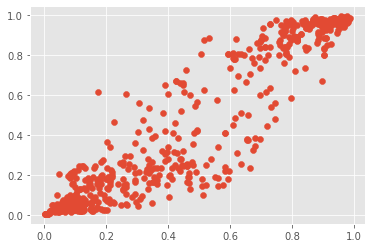

In [1232]:
plt.scatter(meta_train_df['logr'], meta_train_df['ctb']);

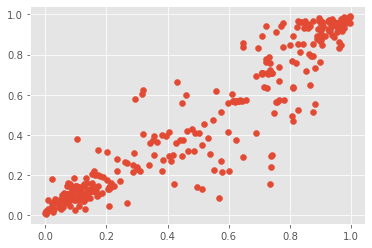

In [1233]:
plt.scatter(y_pred_lr_proba, ctb_prob);

In [1234]:
coef_lr = 0.5
coef_cb = 1 - coef_lr
y_test_1_ens = coef_lr * meta_test_df['logr'] + coef_cb * meta_test_df['ctb']
y_pred_ens = list(map(lambda p: 1 if p >= limit else 0, y_test_1_ens))

In [1235]:
submit(y_pred_ens, 'my_submission_ens_2.csv')
print("Number of Survivers according to the model: {}".format(sum(y_pred_ens)))
print("Real number of Survivers: {}".format(n_surv))

Your submission was successfully saved: my_submission_ens_2.csv
Number of Survivers according to the model: 157
Real number of Survivers: 158


## All 4 Models

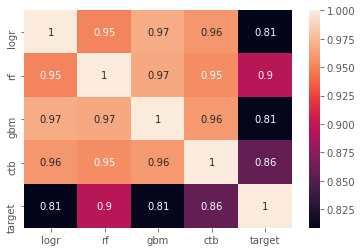

In [1236]:
sns.heatmap(meta_train_df.corr(), annot=True);

In [1237]:
meta_test_df = pd.DataFrame({'logr': y_pred_lr_proba, 'rf': y_pred_rf_proba, 'gbm': y_pred_gbm_proba, 'ctb': ctb_prob})

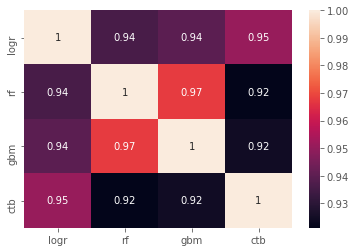

In [1238]:
sns.heatmap(meta_test_df.corr(), annot=True);

In [1239]:
meta_model = LogisticRegression(random_state=RSTATE)
meta_model.fit(meta_train_df.drop(['target'], axis=1), meta_train_df['target'])

LogisticRegression(random_state=12)

In [1240]:
meta_predict = meta_model.predict(meta_test_df)
meta_predict_proba = meta_model.predict_proba(meta_test_df)[:, 1]

In [1241]:
submit(meta_predict, 'my_submission_ens_4.csv')
print("Number of Survivers according to the model: {}".format(sum(meta_predict)))
print("Real number of Survivers: {}".format(n_surv))

Your submission was successfully saved: my_submission_ens_4.csv
Number of Survivers according to the model: 161
Real number of Survivers: 158
